# overview

we will learn  ways to evaluate binary classification models
things we are looking at:
- accuracy
- types of errorsand correct decisions with the confusion table
- precision and recall
- ROC curves
- cross valiation 




In [93]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [95]:
df = pd.read_csv('data/churn.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [96]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [97]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [98]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [99]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

# 4.1 Accuracy and dummy model

- we will evaluate the model on different thresholds
- we will also check the accuracy of the dummy baselines
- we will answer the question of whether 80.3% is good

- accuracy tells us the fraction of correct predictions over the base value.
- basically the number of correct predictions / all predictions

Currently the dicision threshold is 0.5, but it is possible to change this other numbers which may affect accuracy

We will adjust the treshold (the turning point where true becomes false in the result) and get the most optimized value

In [100]:
#we make some thresholds that we can test on
thresholds = np.linspace(0, 1, 21)
scores = []

for t in thresholds:
        churn_decision = (y_pred >= t)
        score = (y_val == churn_decision).mean()
        print(f"{t.round(2)}, {score.round(2)}")
        scores.append(score)

0.0, 0.27
0.05, 0.51
0.1, 0.61
0.15, 0.66
0.2, 0.7
0.25, 0.73
0.3, 0.76
0.35, 0.77
0.4, 0.78
0.45, 0.79
0.5, 0.8
0.55, 0.8
0.6, 0.8
0.65, 0.79
0.7, 0.77
0.75, 0.74
0.8, 0.73
0.85, 0.73
0.9, 0.73
0.95, 0.73
1.0, 0.73


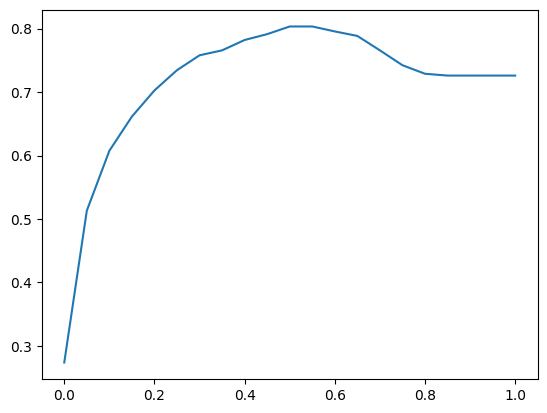

In [101]:
# lets look at the results
# we can see that 0.4 is the best threshold
plt.plot(thresholds, scores)

In [102]:
# there is actually already a way to do this in sklearn

from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred>=0.5)

0.8034066713981547

In [103]:
# now lets do the loop

thresholds = np.linspace(0, 1, 21)
scores = []

for t in thresholds:
        score = accuracy_score(y_val, y_pred >=  t)
        scores.append(score)

what is interesting is the first and last in the graph. These are extere examples but why are the accuracy so good?
<br>
<br>


we can see that if the threshold is 1.0 then the churn rate is 0, but the accuracy is still high (73).

why? well this is because our validatio data set contains lots of non churning users in the y

this is called a class imalance, in this case we have more non churning than churning people in our dataset.

conclusiont: 
## accuracy is quite misleading when there is a class imbalance

# 4.2 Confusion table

- types of erros
- types of correct decisions
- put them in a table called the confusion table


Confusion table is a way of measuring different types of errors and correct decisions that binary classifiers can make. Considering this information, it is possible to evaluate the quality of the model by different strategies.

When comes to a prediction of an LR model, each falls into one of four different categories:

* Prediction is that the customer WILL churn. This is known as the **Positive class**
  * And Customer actually churned - Known as a **True Positive (TP)**
  * But Customer actually did not churn - Known as a **False Positive (FP)**
* Prediction is that the customer WILL NOT churn' - This is known as the **Negative class**
  * Customer did not churn - **True Negative (TN)**
  * Customer churned - **False Negative (FN)**

`Confusion Table` is a way to summarize the above results in a tabular format, as shown below:

<table>
  <tr>
    <th></th>
    <th></th>
    <th colspan="2" style="text-align: center;">Predictions</th>
  </tr>
  <tr>
    <td></td>
    <td></td>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="text-align: center;">TN</td>
    <td style="text-align: center;">FP</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="text-align: center;">FN</td>
    <td style="text-align: center;">TP</td>
  </tr>
</table>

![confusion_matrix.png](./images/Confusion-table.png)

The **accuracy** corresponds to the sum of TN and TP divided by the total of observations.

The code of this project is available in [this jupyter notebook](https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/04-evaluation/notebook.ipynb).

Add notes from the video (PRs are welcome)

Here is a good way to think of the differnet results in the confusion table that can happen
![confusion_matrix.png](./images/Confusion-table-2.png)


In [104]:
# now lets implement

actuall_positive = (y_val == 1)
actuall_negative = (y_val == 0)

t = 0.5 # this is the treshold
predicted_positive = (y_pred >= t)
predicted_negative = (y_pred < t)

true_positive = (predicted_positive & actuall_positive).sum()
true_negative = (predicted_negative & actuall_negative).sum()
false_positive = (predicted_positive & actuall_negative).sum()
false_negative = (predicted_negative & actuall_positive).sum()

In [105]:
# now lets actually make a confusion table with this
confusion_matrix = np.array([
    [true_negative, false_positive],
    [false_negative, true_positive]
])
confusion_matrix

array([[920, 103],
       [174, 212]])

In [106]:
# now lets normalize this, making it into percentage

confusion_matrix / confusion_matrix.sum().round(2)

# we can seee that top left plus bottom right is 80%, which is our accuracy

array([[0.65294535, 0.07310149],
       [0.12349184, 0.15046132]])

# 4.3 Precision and Recall


precision: how many positive predictions are correct

this means what percentage of our predicted positive value is the true positive value


recall: the fraction of correctly identified positive values

this means the pcercentage of our predicted positive value is in the "actual seto of positive values"

these are just two more values that we can use outside of accuracy

In [107]:
precision = true_positive/(true_positive+false_positive)
precision

np.float64(0.6730158730158731)

In [108]:
recall = true_positive / (true_positive + false_negative)
recall

np.float64(0.5492227979274611)

# 4.4 ROC curves

ROC stands for receiver operating characteristic

## TPR
true positive rate (fp/(tn+fp))

## FPR
false positive rate (tp/(fn+tp))

thesea re all gotten from the confusion matrix, and 

In [109]:
tpr = true_positive / (true_positive+false_negative)
tpr

np.float64(0.5492227979274611)

In [110]:
fpr = false_positive / (false_positive+true_negative)
fpr

np.float64(0.10068426197458455)

so ROC curve looks at these two values for all thresholds (that is the point where we decide if it is positive or negative, 0.5 in this case) 

In [111]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actuall_positive = (y_val == 1)
    actuall_negative = (y_val == 0)

    
    predicted_positive = (y_pred >= t)
    predicted_negative = (y_pred < t)

    true_positive = (predicted_positive & actuall_positive).sum()
    true_negative = (predicted_negative & actuall_negative).sum()
    false_positive = (predicted_positive & actuall_negative).sum()
    false_negative = (predicted_negative & actuall_positive).sum()
    
    scores.append((t, true_positive, false_positive, false_negative, true_negative))
    
scores

[(np.float64(0.0), np.int64(386), np.int64(1023), np.int64(0), np.int64(0)),
 (np.float64(0.01), np.int64(385), np.int64(895), np.int64(1), np.int64(128)),
 (np.float64(0.02), np.int64(383), np.int64(804), np.int64(3), np.int64(219)),
 (np.float64(0.03), np.int64(382), np.int64(750), np.int64(4), np.int64(273)),
 (np.float64(0.04), np.int64(382), np.int64(709), np.int64(4), np.int64(314)),
 (np.float64(0.05), np.int64(378), np.int64(678), np.int64(8), np.int64(345)),
 (np.float64(0.06), np.int64(377), np.int64(653), np.int64(9), np.int64(370)),
 (np.float64(0.07), np.int64(374), np.int64(623), np.int64(12), np.int64(400)),
 (np.float64(0.08), np.int64(371), np.int64(588), np.int64(15), np.int64(435)),
 (np.float64(0.09), np.int64(370), np.int64(558), np.int64(16), np.int64(465)),
 (np.float64(0.1), np.int64(366), np.int64(533), np.int64(20), np.int64(490)),
 (np.float64(0.11), np.int64(365), np.int64(511), np.int64(21), np.int64(512)),
 (np.float64(0.12), np.int64(361), np.int64(497), 

In [112]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

In [113]:
#now we get tpr and fpr

df_scores['tpr'] = df_scores.tp/ (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp+df_scores.tn)

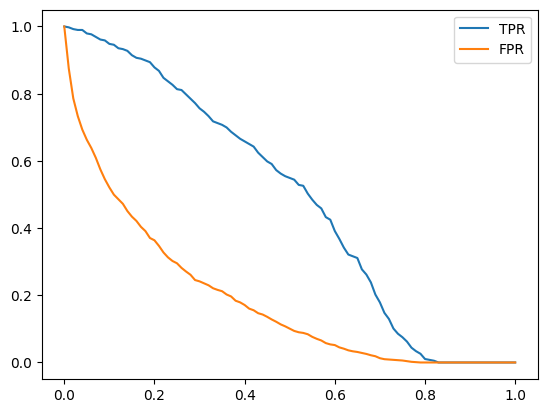

In [114]:
# plot

plt.plot(df_scores.threshold, df_scores['tpr'], label = "TPR")
plt.plot(df_scores.threshold, df_scores['fpr'], label = "FPR")
plt.legend()

## Random model

make decisions completely randomly

In [115]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size = len(y_val))
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089], shape=(1409,))

In [116]:
# get accuracy, which should be the same as threshold

((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [117]:
# now we plot with this

def tpr_fpr_df(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actuall_positive = (y_val == 1)
        actuall_negative = (y_val == 0)

        
        predicted_positive = (y_pred >= t)
        predicted_negative = (y_pred < t)

        true_positive = (predicted_positive & actuall_positive).sum()
        true_negative = (predicted_negative & actuall_negative).sum()
        false_positive = (predicted_positive & actuall_negative).sum()
        false_negative = (predicted_negative & actuall_positive).sum()
        
        scores.append((t, true_positive, false_positive, false_negative, true_negative))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    df_scores['tpr'] = df_scores.tp/ (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp+df_scores.tn)

    return df_scores
    

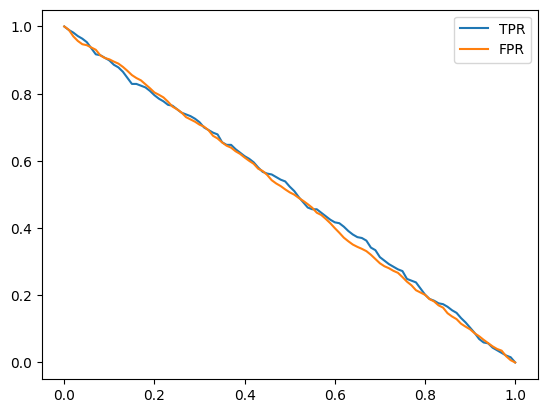

In [118]:
# now lets plot

df_rand = tpr_fpr_df(y_val, y_rand)
plt.plot(df_rand.threshold, df_rand['tpr'], label = "TPR")
plt.plot(df_rand.threshold, df_rand['fpr'], label = "FPR")
plt.legend()

## ideal model

this is the model that gets everything right

it will also be ordered

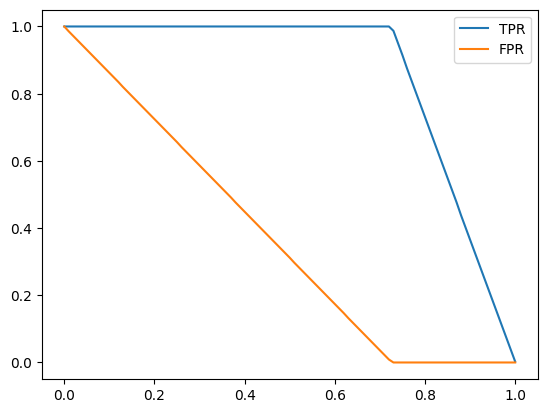

In [119]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

y_ideal = np.repeat([0,1], [num_neg, num_pos])

y_ideal_pred = np.linspace(0, 1, len(y_val))


df_ideal = tpr_fpr_df(y_ideal, y_ideal_pred)
plt.plot(df_ideal.threshold, df_ideal['tpr'], label = "TPR")
plt.plot(df_ideal.threshold, df_ideal['fpr'], label = "FPR")
plt.legend()



## now we put them together

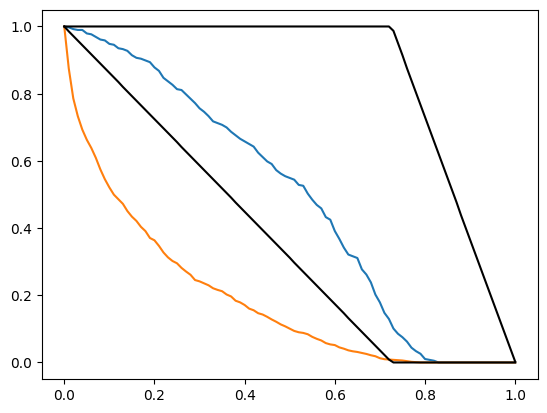

In [120]:
plt.plot(df_scores.threshold, df_scores['tpr'], label = "TPR")
plt.plot(df_scores.threshold, df_scores['fpr'], label = "FPR")
# plt.plot(df_rand.threshold, df_rand['tpr'], label = "TPR")
# plt.plot(df_rand.threshold, df_rand['fpr'], label = "FPR")
plt.plot(df_ideal.threshold, df_ideal['tpr'], label = "TPR", color = 'black')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label = "FPR",  color = 'black')

# our tpr wants to be has far up as the upper line of ideal, same with lower line and fpr

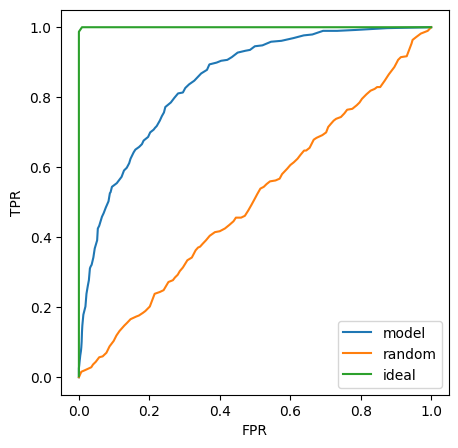

In [121]:
# the problem is that they have 2 different ideal thresholds, so this is what we do
plt.figure(figsize=(5,5))

plt.plot(df_scores.fpr, df_scores.tpr, label= 'model')
plt.plot(df_rand.fpr, df_rand.tpr, label= 'random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label= 'ideal')
plt.ylabel('TPR')
plt.xlabel('FPR')


plt.legend()

We can want the model to be as close ot the ideal one, so as close to a right angle as possible

the bottom left is threshold 1 and right top is 0.

as we can see as the treshold moves, the predict more as churning, so our fpr improves but tpr is going up too. 

a good model will stay close to the ideal line

if it ends up below the random line, that is really bad

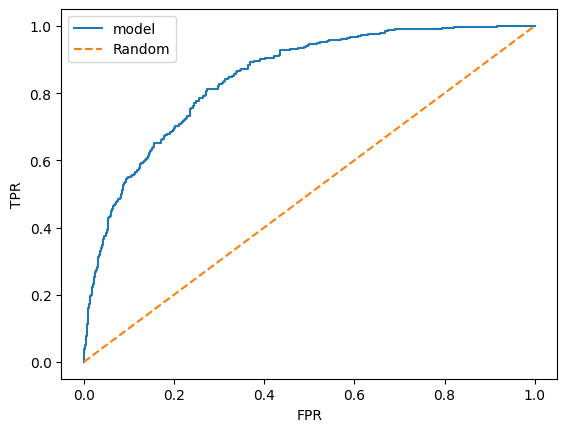

In [122]:
# use sklearn for roc curve

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred)

plt.plot(fpr, tpr, label='model')
plt.plot([0,1],[0,1], label='Random', linestyle='--')


plt.ylabel('TPR')
plt.xlabel('FPR')


plt.legend()


# 4.5 Area under ROC curve

This is another good way to measure this stuff is measuring the area under the curve. 

the bigger the area, the higher better it is

baseline:
- random model: 0.5
- ideal curve: 1.0

In [123]:
# lets implement this

from sklearn.metrics import auc # this iactually for any curve

auc(fpr, tpr)

0.8463626740410962

In [124]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [125]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(df_scores.fpr, df_scores.tpr)


# this is the same as

from sklearn.metrics import roc_auc_score
roc_auc_score(y_val,y_pred)


0.8463626740410962

# 4.6 Cross-validation

this topic includes:
- evaluating the same model on different subsets of data
- getting the avaerage perdiction and the spread within predictions

we will do parameter tuning in this chapter

## K-fold cross validation

**Definition:**  
K-Fold Cross-Validation is a technique to evaluate the generalization performance of a machine learning model by splitting the dataset into `k` folds and systematically training and testing the model on each fold.

---

### Steps

1. **Split the train and validation dataset** into `k` equal (or nearly equal) folds.  
2. **Iterate over each fold**:
   - Use the current fold as the **validation (test) set**.
   - Use the remaining `k-1` folds as the **training set**.
   - Train the model and record the performance metric.
3. **Average the results** from all `k` folds to get the final evaluation score.

---

### Example

For **5-Fold Cross-Validation**:

| Fold | Training Set | Validation Set |
|------|--------------|----------------|
| 1    | 2,3,4,5      | 1              |
| 2    | 1,3,4,5      | 2              |
| 3    | 1,2,4,5      | 3              |
| 4    | 1,2,3,5      | 4              |
| 5    | 1,2,3,4      | 5              |

Final score = average of the performance metrics from all 5 folds.

---

### Why Use K-Fold?

- Reduces variance from a single train/test split.
- Ensures **every data point** is used for training and validation.
- Helps detect **overfitting**.



In [156]:
def train(df_train, y_train, C = 1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C=C, max_iter=100000)
    model.fit(X_train, y_train)
    
    return dv, model
    

In [149]:
dv, model = train(df_train, y_train, C = 0.001)

In [150]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    x = dv.transform(dicts)
    y_pred = model.predict_proba(x)[:, 1]
    return y_pred

In [151]:
ypred = predict(df_val, dv, model)

In [152]:
df_train

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
1814,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0
5946,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,yes,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1
3881,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,yes,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0
2389,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,no,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0
3676,2364-ufrom,male,0,no,no,30,yes,no,dsl,yes,yes,no,yes,yes,no,one_year,no,electronic_check,70.40,2044.75,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,0781-lkxbr,male,1,no,no,9,yes,yes,fiber_optic,no,no,yes,no,yes,yes,month-to-month,yes,electronic_check,100.50,918.60,1
5192,3507-gasnp,male,0,no,yes,60,yes,no,no,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.95,1189.90,0
3980,8868-wozgu,male,0,no,no,28,yes,yes,fiber_optic,no,yes,yes,no,yes,yes,month-to-month,yes,electronic_check,105.70,2979.50,1
235,1251-krreg,male,0,no,no,2,yes,yes,dsl,no,yes,no,no,no,no,month-to-month,yes,mailed_check,54.40,114.10,1


In [162]:
# now lets do the kfold stuff

# to see progress, pip isntall tqdm

from tqdm.auto import tqdm

# we will iterate over different values of c (regularization)
for C in tqdm([0.00001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10]):


    from sklearn.model_selection import KFold

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    kfold.split(df_full_train)

    #train and validation index
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        y_train = df_train.churn.values
        y_val = df_val.churn.values
        
        dv, model = train(df_train, y_train, C)
        y_pred = predict(df_val, dv, model)
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append(auc)
    
    print('C = %s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))







  0%|          | 0/8 [00:00<?, ?it/s]

C = 1e-05 0.803 +- 0.009
C = 0.001 0.825 +- 0.009
C = 0.01 0.840 +- 0.008
C = 0.1 0.842 +- 0.007
C = 0.5 0.842 +- 0.007
C = 1 0.842 +- 0.007
C = 5 0.842 +- 0.007
C = 10 0.842 +- 0.007


In [ ]:
# now we train the whole thing

dv, model = train(df_full_train, df_full_train.churn.values, C = 1)
y_pred = predict(df_test, dv, model)
auc = roc_auc_score(y_test, y_pred)
auc

# and now we see the AUC is a bit better


0.8584573759303195

### When should we do k fold?

- small datasets:
  - if we have small to medium datasets, it is better to use this since a single train/split can lead to a biased estimate
  - k-fold ensures every sample gets to be in the test set once and training k-1 times

- hyperparameter tuning: when selecting params (like C in SVR or depth in trees) this lets you compare settings without overfitting to a single split

- do not use on large datasets or time series data
